# Importing Libraries 


In [90]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Time Series Tasks 

#### 1. Convert the longitudinal blood pressure measurements into a proper time series:
   - Create a pandas Series with DatetimeIndex using `visit_date`
   - Handle any missing or duplicate measurements appropriately
   - Tips: 
     - Use `pd.to_datetime()` with format='%Y-%m-%d' for reliable parsing
     - Handle duplicates with `duplicated()` and appropriate aggregation
     - Consider timezone handling with `tz_localize()` if needed
     - Use `interpolate()` or `fillna()` for missing values

In [ ]:
#Reading in data and converting it to Pandas Dataframe 
long_data = pd.read_csv("/Users/MuskaanSandhu/08-time-stats-and-ml-muskaansandhu/patient_longitudinal.csv", sep = '\t')
long_data = pd.DataFrame(long_data)

#Converting visit_date to DateTime object 
long_data['visit_date'] = pd.to_datetime(long_data['visit_date'], format='%Y-%m-%d')

#Checking for duplicates based on Patient IDs that were were recorded on the same visit data 
duplicates = long_data[long_data.duplicated(subset=['patient_id', 'visit_date'], keep=False)]
display(duplicates) #There are 2000 rows of duplicted entries.

#Aggregating duplicated entries to get the mean of measures for continuous variables and the maximum values for binary variables (this will capture if an instance for diabetes, smoking, etc. occured)
duplicates_aggregated = duplicates.groupby(['patient_id', 'visit_date']).agg({
    'bp_systolic': 'mean',
    'heart_rate': 'mean',
    'adverse_event': 'max', 
    'age': 'mean', 
    'sex': 'max',
    'smoking': 'max',
    'diabetes': 'max', 
    'bmi':'mean'
}).reset_index()

#Removing all duplicate entries from the original dataframe: 
long_data_drop_duplicates = long_data.drop_duplicates(subset=['patient_id', 'visit_date'], keep=False)

#Adding the aggregated duplicated data entries to original dataframe 
long_data_clean = pd.concat([long_data_drop_duplicates, duplicates_aggregated], ignore_index=True)

#Checking for NAs and duplicated values 
print(long_data_clean.isna().sum()) #There are no missing values, no need to use interpolate() or fillna()

#Setting the index date to 'visit_date' and displaying the clean dataset 
long_data_clean.set_index('visit_date', inplace=True)
display(long_data_clean)


,patient_id,visit_date,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
50,0,2027-02-17,110.7,65.7,0,57.5,0.0,25.8,0.0,0.0
51,0,2027-02-17,111.3,69.9,0,57.5,0.0,25.8,0.0,0.0
111,1,2027-02-17,119.7,77.0,0,47.9,0.0,23.2,0.0,0.0
112,1,2027-02-17,119.1,71.8,0,47.9,0.0,23.2,0.0,0.0
172,2,2027-02-17,126.7,90.3,0,59.7,1.0,29.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
60868,997,2027-02-17,118.3,45.8,0,59.6,1.0,22.2,0.0,1.0
60928,998,2027-02-17,142.2,65.0,0,41.4,0.0,24.2,0.0,0.0
60929,998,2027-02-17,150.3,64.7,0,41.4,0.0,24.2,0.0,0.0
60989,999,2027-02-17,121.9,99.5,0,58.6,0.0,25.6,0.0,0.0


patient_id       0
visit_date       0
bp_systolic      0
heart_rate       0
adverse_event    0
age              0
sex              0
bmi              0
smoking          0
diabetes         0
dtype: int64


,patient_id,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
visit_date,,,,,,,,,
2023-01-17,0,108.60,72.40,0,57.5,0.0,25.8,0.0,0.0
2023-02-22,0,104.80,71.90,0,57.5,0.0,25.8,0.0,0.0
2023-03-23,0,106.30,76.20,0,57.5,0.0,25.8,0.0,0.0
2023-04-16,0,110.80,76.50,0,57.5,0.0,25.8,0.0,0.0
2023-06-05,0,117.70,78.40,0,57.5,0.0,25.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2027-02-17,995,109.95,91.85,0,45.8,0.0,23.6,0.0,0.0
2027-02-17,996,129.20,78.75,0,77.0,0.0,22.1,0.0,1.0
2027-02-17,997,118.55,45.15,0,59.6,1.0,22.2,0.0,1.0


#### 2. Analyze blood pressure trends:
   - Resample the data to monthly frequency using mean aggregation
   - Calculate 3-month moving averages to smooth out short-term fluctuations
   - Visualize both the original and smoothed trends
   - Tips:
     - Use `resample('ME').mean()` for month-end frequency
     - Add `min_periods` to `rolling()` to handle edge cases
     - Consider `interpolate()` method for gaps
     - Use `ewm()` for exponential weighted alternatives

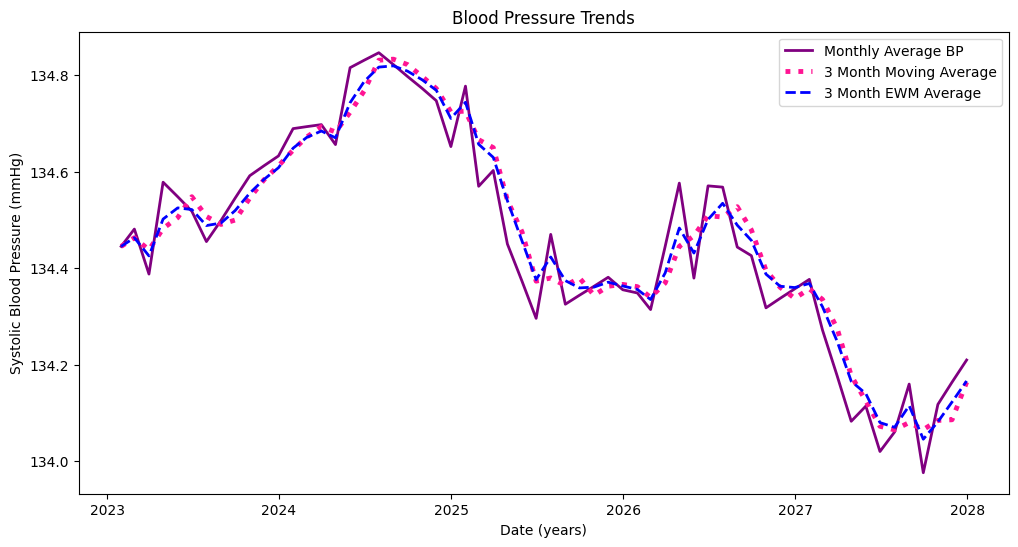

In [114]:
#Resampling data to monthly frequencies using mean aggregation 
SBP_monthly = long_data_clean['bp_systolic'].resample('ME').mean()

#Checking for missing values 
SBP_monthly.isna().sum() #There are 15 months with missing values 

#Interpolating missing values 
SBP_monthly = SBP_monthly.interpolate()

#Calculating 3 month moving averages to smooth out short-term flunctuations 
SBP_3month = SBP_monthly.rolling(window=3, min_periods=1).mean()

#Using ewm() for exponential weighted averages 
SBP_3month_ewm = SBP_monthly.ewm(span=3, adjust=False).mean()

#Plotting all three curves 
plt.figure(figsize=(12, 6))
plt.plot(SBP_monthly, label='Monthly Average BP', color='purple', linewidth=2)
plt.plot(SBP_3month, label='3 Month Moving Average', color='deeppink', linestyle='dotted', linewidth=3.5)
plt.plot(SBP_3month_ewm, label='3 Month EWM Average', color='blue', linestyle='dashed', linewidth=2)

plt.title('Blood Pressure Trends')
plt.xlabel('Date (years)')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.legend()
plt.show()

# Statistical Modeling Tasks 

#### 1. Analyze factors affecting baseline blood pressure:
   - Use statsmodels OLS to predict `bp_systolic`
   - Include `age`, `bmi`, `smoking`, and `diabetes` as predictors
   - Interpret the coefficients and their p-values
   - Assess model fit using R-squared and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term using `sm.add_constant()`
     - Use `sm.OLS(y, X).fit()` to fit the model
     - Use `summary()` to examine p-values and confidence intervals
     - Plot residuals vs fitted values and Q-Q plot
     - Consider robust standard errors with `HC3` covariance type

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     150.2
Date:                Tue, 05 Nov 2024   Prob (F-statistic):          1.65e-100
Time:                        17:49:16   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      2.000     54.252      0.0

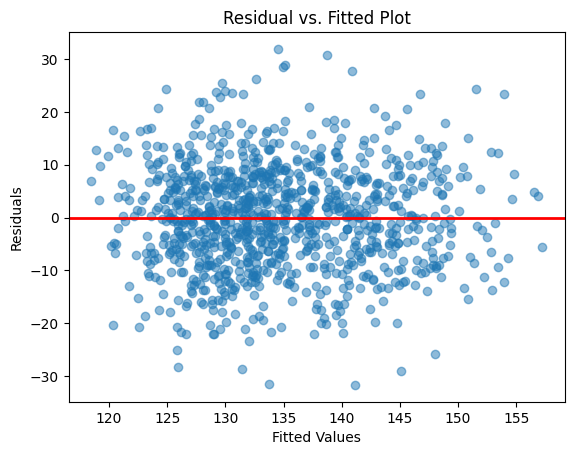

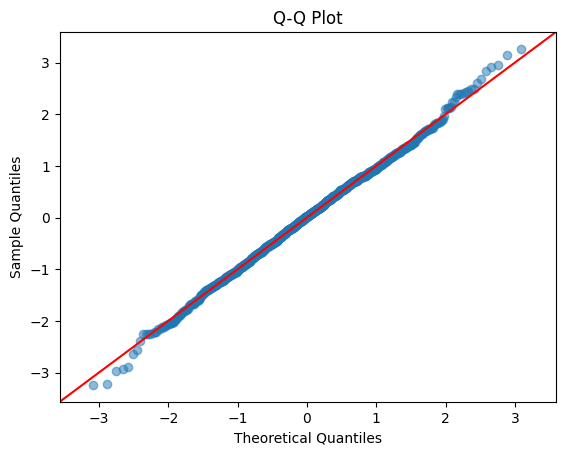

In [89]:
#Loading in baseline dataset
baseline_data = pd.read_csv("/Users/MuskaanSandhu/08-time-stats-and-ml-muskaansandhu/patient_baseline.csv", sep = '\t')

#Predictor variables (age, smoking, BMI, and diabetes)
predictors = baseline_data[['age', 'smoking', 'bmi', 'diabetes']]

#Outcome variable 
outcome = baseline_data['bp_systolic']

#Adding constant term 
predictors = sm.add_constant(predictors)

#Setting up OLS model 
OLS_model = sm.OLS(outcome,predictors).fit()

#Printing summary results of model 
print(OLS_model.summary())

#Plotting residuals vs. fitted values 
plt.scatter(OLS_model.fittedvalues, OLS_model.resid, alpha=0.5)
plt.axhline(y=0, linewidth=2, color='r')
plt.title('Residual vs. Fitted Plot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

#Plotting Q-Q plot 
sm.qqplot(OLS_model.resid, line='45', fit=True, alpha=0.5)
plt.title('Q-Q Plot')
plt.show()


Based on our summary of our OLS model, all of the predictors we used (age, BMI, smoking, and diabetes) are significantly associated with systolic BP with p-values approximately 0, less than an alpha of 0.05. Out of all predictors, diabetes and BMI had the greatest average change. Those with diabetes have an average increase of 9.97 mmHg (95% CI: 8.42, 11.33), holding all other variables constant. For those that are smokers, holding all other variables constant, the average SBP increased by 5.42 mmHg (95% CI: 3.86, 6.61). In terms of age and BMI, for each unit increase of both, average SBP increase by 0.28 mmHg (95% CI 'age': 0.24, 0.33 / 95%CI 'BMI': 0.15, 0.41) accounting for other variables. 

In terms of model performance, the Residuals vs Fitted plot is unbiased and homoscedastic, showing the points scattered randomly and evenly across y=0. The Q-Q plot shows us that our residuals, for the most part, are normally distributed. The R-squared value of 0.37 indicates that around 37% of the of the variability in SBP is explained by the predictors in the model. This fit is not the greatest and could be improved by adding additonal predictors available. 

#### 2. Model treatment effectiveness:
   - Fit a GLM with binomial family to predict treatment success
   - Use baseline characteristics and `adherence` as predictors
   - Report odds ratios and their confidence intervals
   - Assess model fit using deviance and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term
     - Use `sm.GLM(y, X, family=sm.families.Binomial()).fit()`
     - Get odds ratios with `np.exp(params)`
     - Check residual deviance vs null deviance
     - Use `influence()` to detect influential observations

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -656.42
Date:                Wed, 06 Nov 2024   Deviance:                       1312.8
Time:                        11:46:08   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01896
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2681      0.691     -1.836      0.0

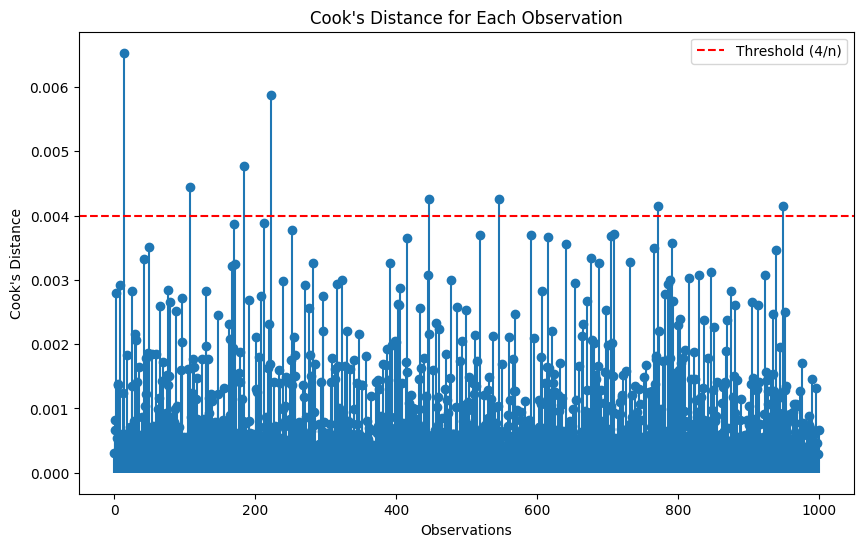

In [ ]:
#Loading in treatment dataset 
treatment_data = pd.read_csv('/Users/MuskaanSandhu/08-time-stats-and-ml-muskaansandhu/patient_treatment.csv', sep='\t')

#Defining predictors (age, bmi, smoking, diabetes, adherence)
predictors_GLM = treatment_data[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]

#Defining outcome variable 
outcome_GLM = treatment_data['outcome']

#Adding constant term to predictors 
predictors_GLM = sm.add_constant(predictors_GLM)

#Setting up GLM model
GLM_model = sm.GLM(outcome_GLM, predictors_GLM, family=sm.families.Binomial()).fit()

#Printing GLM model summary
print(GLM_model.summary())

#Odds Ratio and CIs using np.exp(params)
print("Odds Ratios:\n", np.exp(GLM_model.params))
print("Confidence intervals:\n", np.exp(GLM_model.conf_int()))

#Residual deviance vs null deviance 
print("Residual deviance:", GLM_model.deviance)
print("Null deviance:", GLM_model.null_deviance)

#Detecting influential observations 
influence = GLM_model.get_influence()
cooks = influence.cooks_distance[0]

#Plotting influential observations 
plt.figure(figsize=(10,6))
plt.stem(np.arange(len(cooks)), cooks, basefmt=" ")
plt.title("Cook's Distance for Each Observation")
plt.xlabel('Observations')
plt.ylabel("Cook's Distance")
plt.axhline(y=4/len(cooks), color='r', linestyle='--', label="Threshold (4/n)")  # Threshold line
plt.legend()
plt.show()

Based on the output of the model, BMI and diabetes are significantly correlated to treatment success. For every one unit increase in BMI, the odds of treatment success increase by 3% based on an odds ratio of 1.03 (95CI%: 1.00, 1.05) holding all other predictors constant. Accounting for the other predictors in the model, for those with diabetes, treament success decreases by 38.66% based on an odds ratio of 0.61 (95%CI: 0.43,0.85). 

Comparing the null deviance to the residual deviance, we don't see much of a difference between the two values (1331.97-1312.83 = 19.14). This small diference suggests that when the predictors were added to the model, the fit of the model was not improved significantly. When looking at the Cook's Distance plot, we see that there are 8 influential obseravations based on the threshold of 4/n (n = number of observations). 